<a href="https://colab.research.google.com/github/dmschauer/Google-Colab-Notebooks/blob/master/Realtime_age_and_gender_prediction_using_keras_tensorflow_and_Open_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import tensorflow as tf

Go to the www.kaggle.com homepage -> Your Account -> Create New API token
For example I go to https://www.kaggle.com/dominikschauer/account, click the button and save my kaggle.json locally. 

Place your downloaded file into the directory /content/. You should see the file when executing the following command.

In [36]:
!ls /content/

1592072050228.jpg  1592072161380.jpg  file1.jpg    sample_data
1592072101994.png  age_kaggle_b.h5    kaggle.json  temp_pic.jpg


The following code will move the file from / to the hidden folder /root/.kaggle. The Python library kaggle requires it to be placed there.


In [0]:
!mkdir -p /root/.kaggle
!mv /content/kaggle.json /root/.kaggle

Now you should see kaggle.json when executing the following command.

In [39]:
!ls /root/.kaggle

kaggle.json


Change the access rights

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

Now you are ready to use the Kaggle API via the Kaggle command line tool which is a built-in part of the Python library kaggle. The following code list all datasets on Kaggle which are related to the keyword "utk".

In [0]:
!kaggle datasets list -s utk

ref                        title              size  lastUpdated          downloadCount  
-------------------------  ----------------  -----  -------------------  -------------  
jangedoo/utkface-new       UTKFace           331MB  2018-08-16 19:05:30           1423  
abhikjha/utk-face-cropped  UTK Face Cropped  232MB  2019-05-03 18:35:14            389  
bachng/utkface-db          UTKFace_DB        232MB  2019-05-21 00:05:01              5  


For this tutorial we will download the jangedoo/utkface-new dataset



In [0]:
!kaggle datasets download -d jangedoo/utkface-new

 95% 316M/331M [00:02<00:00, 125MB/s]
100% 331M/331M [00:02<00:00, 132MB/s]


In [0]:
!ls /content

sample_data  utkface-new.zip


Unzip the file. It contains about 24k images so it will take a few seconds.

In [0]:
!unzip /content/utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170105164106

In [47]:
import os

DATA_DIR = '/content/UTKFace/'

files = os.listdir(DATA_DIR)
files[1:10]

['62_0_0_20170104212928133.jpg.chip.jpg',
 '34_0_1_20170116002253177.jpg.chip.jpg',
 '25_0_1_20170116002837310.jpg.chip.jpg',
 '26_0_3_20170119165526055.jpg.chip.jpg',
 '45_1_0_20170117175326912.jpg.chip.jpg',
 '26_1_1_20170112212042603.jpg.chip.jpg',
 '26_1_2_20170116180014046.jpg.chip.jpg',
 '2_1_4_20161221195003500.jpg.chip.jpg',
 '40_0_0_20170105172604533.jpg.chip.jpg']

# Age detection model

In [48]:
age_classes=[]

for i in range(0,len(files)):
  age=files[i].split('_')[0]
  age = int(age)
  if age <= 14:
    age_classes.append(0)
  if (age>14) and (age<=25):
    age_classes.append(1)
  if (age>25) and (age<40):
    age_classes.append(2)
  if (age>=40) and (age<60):
    age_classes.append(3)
  if age>=60:
    age_classes.append(4)

age_classes[1:10]

[4, 2, 1, 2, 3, 2, 2, 0, 3]

In [0]:
from PIL.Image import *

faces=[]

for i in range(0,len(files)):
  image = open(DATA_DIR+files[i])
  image = image.resize((32,32))
  image = np.asarray(image)
  faces.append(image)

We then need to squeeze this faces list and divide it by 255 to get the values between 0 and 1.

In [0]:
#faces=faces.astype('float32')
faces = np.array(faces, dtype=np.float32)
faces = faces/255

Once, you’re done, we run this piece of code to check if every has worked out perfectly or not.

In [51]:
faces.shape

(23708, 32, 32, 3)

This should give you the following output: (23708, 32, 32, 3).
This means everything has worked the way we intend to do.

Now, we prepare our model whose architecture is given below:

In [52]:
model = tensorflow.keras.Sequential()
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

We then compile our model and also convert our labels to categorical parts which is a requirement of CNN.
The following piece of code does this for you.


In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 

from keras.utils.np_utils import to_categorical
age_classes=to_categorical(age_classes,num_classes=5)

We then train our model for 25 epochs, and the accuracy which we get is given below:

In [0]:
model.fit(faces,age_classes,epochs=25)

Epoch 1/25
741/741 [==============================] - 31s 41ms/step - loss: 1.1366 - accuracy: 0.5190
Epoch 2/25
741/741 [==============================] - 30s 41ms/step - loss: 0.9789 - accuracy: 0.5768
Epoch 3/25
741/741 [==============================] - 30s 41ms/step - loss: 0.9238 - accuracy: 0.5992
Epoch 4/25
741/741 [==============================] - 30s 41ms/step - loss: 0.8887 - accuracy: 0.6123
Epoch 5/25
741/741 [==============================] - 30s 41ms/step - loss: 0.8594 - accuracy: 0.6276
Epoch 6/25
741/741 [==============================] - 30s 41ms/step - loss: 0.8308 - accuracy: 0.6373
Epoch 7/25
741/741 [==============================] - 30s 41ms/step - loss: 0.8101 - accuracy: 0.6461
Epoch 8/25
741/741 [==============================] - 30s 40ms/step - loss: 0.7827 - accuracy: 0.6577
Epoch 9/25
741/741 [==============================] - 30s 40ms/step - loss: 0.7609 - accuracy: 0.6696
Epoch 10/25
741/741 [==============================] - 30s 40ms/step - loss: 0.738

You likely arrived at an accuracy somewhere around 85%. The accuracy is pretty good considering the complexity of our data. We then save the model for further use using the code given below. Make sure to also save your model to your local harddrive as all files on the remote drive will be lost in case your current Google Colab session stops.

In [0]:
model.save('/content/age_kaggle_b.h5')

In case you didn't train your own model, this is how you can load the model I trained. You can download it ##here##. Make sure to put it into the /content/ directory before running the next lines.

In [0]:
model = tf.keras.models.load_model('/content/age_kaggle_b.h5')

Let's have a simple test run.

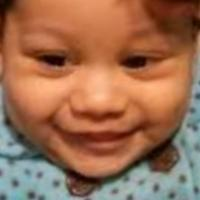

In [126]:
from IPython.display import Image, display
display(Image('/content/UTKFace/' + files[0]))

In [0]:
image_dt=open(DATA_DIR + files[0])
image_dt=image_dt.resize((32,32))
image_dt=np.expand_dims(image_dt,axis=0)
image_dt=image_dt/255

In [164]:
np.set_printoptions(suppress=True)

class_predictions = model.predict(image_dt)
prediction = np.argmax(class_predictions, axis=-1)

print(prediction)

[2]


You can also try images you found on the web. Note that you should use pictures in the .jpg format and that the model works better in the face is clearly visible and takes up most of the picture. To get past the seconds limitation we would have to add a step that extracts the face from an image. IT also works better with colored picturs (e.g. no black and white photographs).

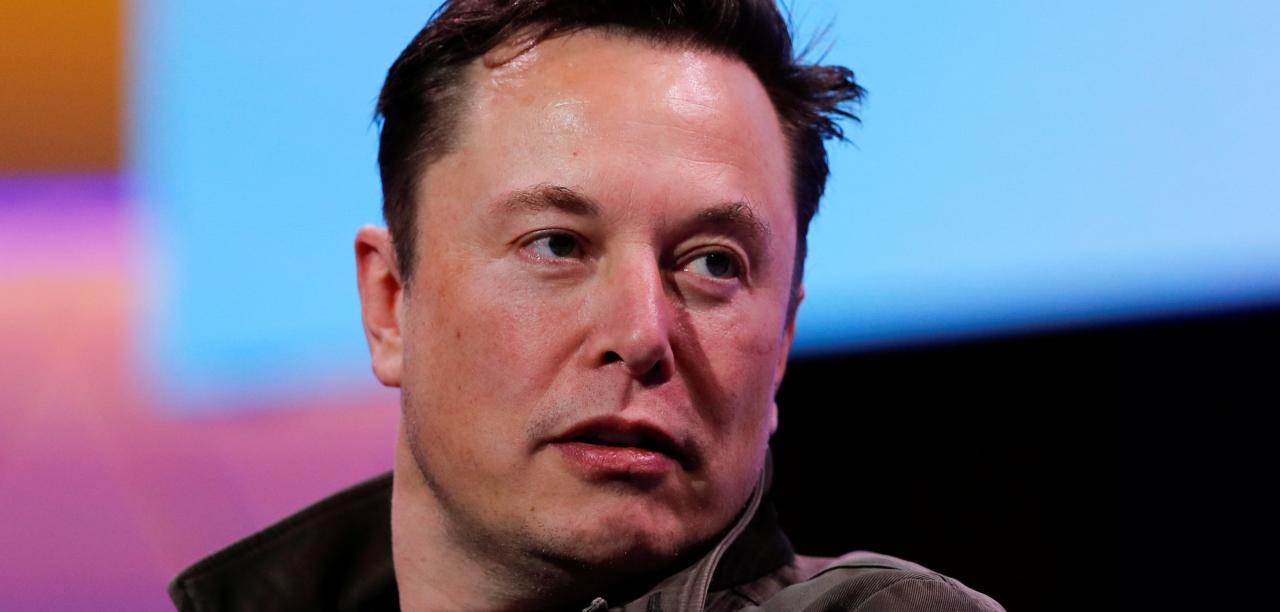

[[0.00050614 0.02954636 0.9533286  0.01049916 0.00611986]]
[2]


In [33]:
from IPython.display import Image, display
import urllib.request

url = "https://www.welt.de/img/wirtschaft/mobile202861736/7561627187-ci23x11-w1280/FILE-PHOTO-SpaceX-owner-and-Tesla-CEO-Elon-Musk-speaks-during-a.jpg"
destination = '/content/temp_pic.jpg'

urllib.request.urlretrieve(url, destination)

display(Image(destination))

image_dt=open(destination)
image_dt=image_dt.resize((32,32))
image_dt=np.expand_dims(image_dt,axis=0)
image_dt=image_dt/255


np.set_printoptions(suppress=True)

class_predictions = model.predict(image_dt)
prediction = np.argmax(class_predictions, axis=-1)

print(class_predictions)
print(prediction)

Let's have some more test runs.

In [0]:
NUM_PREDICTIONS = 30

predictions = []

for i in range(0,NUM_PREDICTIONS):
  image_dt=open(DATA_DIR + files[i])
  image_dt=image_dt.resize((32,32))
  image_dt=np.expand_dims(image_dt,axis=0)
  image_dt=image_dt/255

  class_predictions = model.predict(image_dt)
  prediction = np.argmax(class_predictions, axis=-1)

  predictions.append(prediction[0])

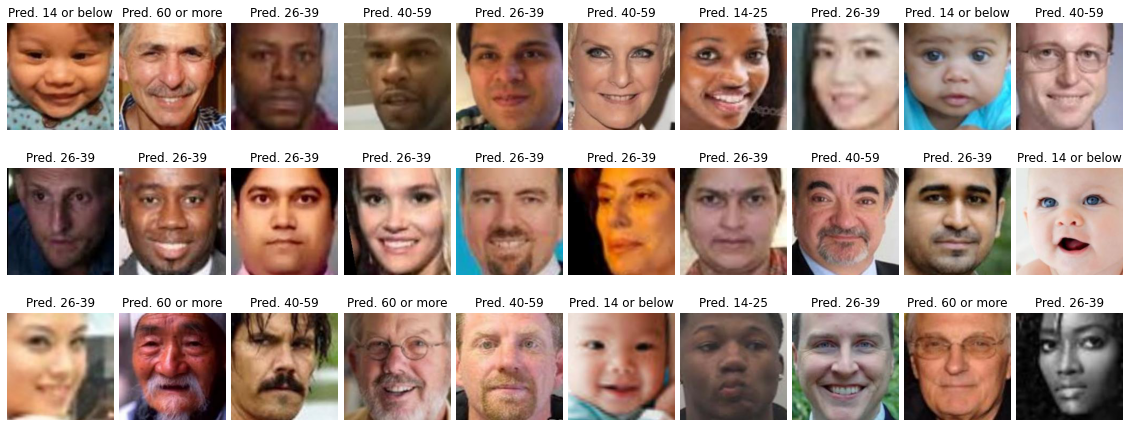

In [163]:
from PIL import Image

def get_class_name(class_number):
  options = {0 : '14 or below',
           1 : '14-25',
           2 : '26-39',
           3 : '40-59',
           4 : '60 or more'}
  return(options[class_number])

file_paths = []
for file in files: 
  file_paths.append('/content/UTKFace/'+file)

file_paths = file_paths[0:NUM_PREDICTIONS]

images = [Image.open(f) for f in file_paths]

max_cols = 10
max_rows = NUM_PREDICTIONS // max_cols

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx, image in enumerate(images):
  row = idx // max_cols
  col = idx % max_cols
  axes[row, col].axis("off")
  axes[row, col].imshow(image, cmap="gray")
  axes[row, col].set_title('Pred. ' + get_class_name(predictions[idx]))

plt.subplots_adjust(wspace=.05, hspace=0)
plt.show()

With this, we have successfully completed our age detection part. We now move on to the gender detection part.

# Gender detection model

For classifying gender into 2 categories (male and female) , we use the dataset available in Kaggle which is called Men/Women Classification (https://www.kaggle.com/playlist/men-women-classification) which contains roughly 3.5k images of both men and women.
For this part, we will use the pretrained VGG16 Model with weights as ‘ImageNet’. We also do not include the final dense layer. These are already available in keras and we can do so by using this piece of code given below:


First get the dataset.

In [0]:
!kaggle datasets list -s men-women-classification

ref                                                       title                                       size  lastUpdated          downloadCount  
--------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  
playlist/men-women-classification                         Men/Women Classification                     1GB  2019-04-09 14:14:58           2072  
saadpd/menwomen-classification                            Men-Women Classification                   806MB  2020-01-19 13:27:07            150  
fivethirtyeight/fivethirtyeight-comic-characters-dataset  FiveThirtyEight Comic Characters Dataset   597KB  2019-04-26 15:01:41           8148  
jboysen/mri-and-alzheimers                                MRI and Alzheimers                          13KB  2017-08-16 17:18:10           7994  
mrisdal/married-at-first-sight                            Married at First Sight                       2KB  2020-05-09 07:25:16   

In [40]:
!kaggle datasets download -d playlist/men-women-classification

 99% 1.17G/1.19G [00:22<00:00, 43.9MB/s]
100% 1.19G/1.19G [00:22<00:00, 56.5MB/s]


In [0]:
!mkdir -p /content/gender
!mv /content/men-women-classification.zip /content/gender
!unzip /content/gender/men-women-classification.zip -d /content/gender

In [46]:
DATA_DIR = '/content/gender/data/'

files_men=os.listdir(DATA_DIR+'men')
print(files_men[0])

files_women=os.listdir(DATA_DIR+'women')
print(files_women[0])

00000936.jpg
00000936.jpg


You might have to restart your Runtime before you proceed due to verison conflicts between Keras and tensorflow. In case you receive error messages while executing the following code, click the Runtime tab -> Restart runtime.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import keras
import tensorflow

In [0]:
from keras.models import Sequential
from keras.layers import *

In [50]:
from keras import Model
from keras.applications.vgg16 import VGG16

rs =VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')
for layer in rs.layers:
    layer.trainable=False
x=Flatten()(rs.output)
a=Dense(32,activation='relu')(x)

b=Dense(2,activation='softmax')(a)

model=Model(inputs=rs.input,outputs=b)

model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

We then use our ImageDataGenerator to make the model available in the required format. This is the usual step and we can also read more about this from the Keras Documentation. Here I use a 50:50 training-validation split. I mostly do this to speed up the training process. In a real application I would use more pictures for training.

In [64]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.5,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    '/content/gender/data/',
    target_size=(224, 224),
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    '/content/gender/data/', # same directory as training data
    target_size=(224, 224),
    subset='validation',
    class_mode='categorical') # set as validation data

Found 1655 images belonging to 2 classes.
Found 1654 images belonging to 2 classes.


We then train it for 5 epochs and the result which we get is attached below. This will take a good while. Expect at least 30-60 minutes on Google Colab. Again, alternatively you can download the model I trained ##here## and load this pretrained model below.

In [65]:
model_gender.fit_generator(
        train_generator,
        epochs=5)

Epoch 1/5
52/52 [==============================] - 874s 17s/step - loss: 0.6467 - accuracy: 0.6876
Epoch 2/5
52/52 [==============================] - 866s 17s/step - loss: 0.3681 - accuracy: 0.8344
Epoch 3/5
52/52 [==============================] - 864s 17s/step - loss: 0.3190 - accuracy: 0.8647
Epoch 4/5
52/52 [==============================] - 864s 17s/step - loss: 0.3068 - accuracy: 0.8628
Epoch 5/5
52/52 [==============================] - 864s 17s/step - loss: 0.2356 - accuracy: 0.8991


We again save our model using the Keras save function. 

Once again, remember to save this model to your disk as well.

In [0]:
model_gender.save('/content/gender_final_a.h5')

Again, you could also use my pre-trained model like this after you put it into the correct folder first.

In [0]:
model_gender = tf.keras.models.load_model('/content/gender_final_a.h5')

At this point we prepared both our models.

# OpenVC

We now need to use OpenCV to detect faces and apply both of our saved models. Detecting faces in OpenCV is quite simple and for this we will use the Haarcascade Frontal Face Detector XML File. After detecting the faces, we will also draw a bounding box which is our region of interest and apply our models on the same rectangle (the bounding box) .The whole piece of code is attached below.

**Caution:** The following script is intended to be run on your laptop, where you can access your webcam. It won't work on Google Colab. However you will use the models you just trained on Colab to do the age and gender prediction part. 

To use the following code, save it into a .py file on your local harddrive.

I added some comments to the script, so it should be clear how it ties together.

To install the Python library cv2 you can use either of the following if you have installed pip or conda respectively:
*   pip install opencv-python
*   conda install opencv-python

For PIL the commands are:
*   pip install pillow
*   conda install pillow

Alternatively, you can try to use thse sources to implement your own version:
* https://github.com/googlecolab/colabtools/issues/560
* https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi

In [0]:
import cv2
import numpy as np
from keras.models import load_model
import tensorflow as tf
from PIL.Image import *

# Load models
model_gender = tf.keras.models.load_model('C:\Users\DominikSchauer\Documents\Python Scripts\\webcam_age_gender_prediction\\contents\\gender_final_a.h5')
model_age = tf.keras.models.load_model('C:\Users\DominikSchauer\Documents\Python Scripts\\webcam_age_gender_prediction\\contents\\age_kaggle_b.h5')

# Define colors for gender prediction
labels_dict_gender = {0:'male',1:'female'}
color_dict_gender = {0:(252, 186, 3),
                     1:(216, 168, 224)}

# Define colors for age prediction
labels_dict_age = {0:'0-14',1:'15-25',2:'26-40',3:'40-60',4:'60+'}
color_dict_age = {0:(255,215,0),
                  1:(255,165,0),
                  2:(255,140,0),
                  3:(255,69,0),
                  4:(220,20,60)}

# Load Open CV face classifier
face_clsfr = cv2.CascadeClassifier('C:\Users\DominikSchauer\Documents\Python Scripts\\webcam_age_gender_prediction\\contents\\haarcascade_frontalface_default.xml')

# Define webcam as input
source = cv2.VideoCapture(0)

while(True):
  # Get webcam input
  ret,img = source.read()
  
  # Turn webcam input black and white and detect faces
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_clsfr.detectMultiScale(gray,1.3,5)  
  
  # Draw bounding boxes around each face detected by the haarcascade frontalface classifier
  for (x,y,w,h) in faces:
    # Black and white image
    face_img = gray[y:y+w,x:x+w]

    # Prepare webcam input for gender prediction
    resized_gender = cv2.resize(face_img,(224,224))
    resized_gender = cv2.cvtColor(resized_gender,cv2.COLOR_GRAY2RGB)
    reshape_gender=np.expand_dims(resized_gender,axis=0)
    normalized_gender = reshape_gender/255.0

    # Prepare webcam input for age prediction
    resized_age = cv2.resize(face_img,(32,32))
    resized_age = cv2.cvtColor(resized_age,cv2.COLOR_GRAY2RGB)
    reshape_age = np.expand_dims(resized_age,axis=0)
    normalized_age = reshape_age/255.0
    
    # Predict gender
    class_predictions_gender = model_gender.predict(normalized_gender)
    prediction_gender = np.argmax(class_predictions_gender, axis=-1)    

    # Predict age
    class_predictions_age = model_age.predict(normalized_age)
    prediction_age = np.argmax(class_predictions_age, axis=-1) 
    
    # Draw bounding box, 
    # color is chosen according to gender
    cv2.rectangle(img, (x,y), (x+w,y+h), 
                  color_dict_gender[prediction_gender], 2)
    
    # Put gender label 25px above bounding box,
    # color is chosen according to gender prediction
    cv2.putText(img, 'Gender: ' + labels_dict_gender[prediction_gender], 
                (x,y-25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_dict_gender[prediction_gender], 2)
    
    # Put age label 5px above bounding box,
    # color is chosen according to age prediction
    cv2.putText(img, 'Age: ' + labels_dict_age[prediction_age], 
                (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_dict_age[prediction_age], 2)
    
  # Display webcam image including all bounding boxes and predictions
  cv2.imshow('LIVE',img)
  key=cv2.waitKey(1)
    
  # Close window and end programm when hitting ESC (key 27)
  if(key==27):
    cv2.destroyAllWindows()
    break

So the real deal will be run on your local machine. However if you don't want to go through all the hassle we can check the deep learning part of the working in Colab. 

Unfortunately you won't get the cool real-time prediction this way, but you wou will get the idea. Here you go:

In [4]:
import cv2
import numpy as np
from keras.models import load_model
import tensorflow as tf
#from PIL.Image import *

Using TensorFlow backend.


In [0]:
model_gender = tf.keras.models.load_model('/content/gender_final_a.h5')
model_age = tf.keras.models.load_model('/content/age_kaggle_b.h5')

In [0]:
face_clsfr = cv2.CascadeClassifier('/cotent/haarcascade_frontalface_default.xml')

Take a photo and save it in Google Colab. The file will be deleted after your current session stops.

In case you get an error message, restart the runtime and this time don't import PIL.image.

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to /content/webcamphoto.jpg


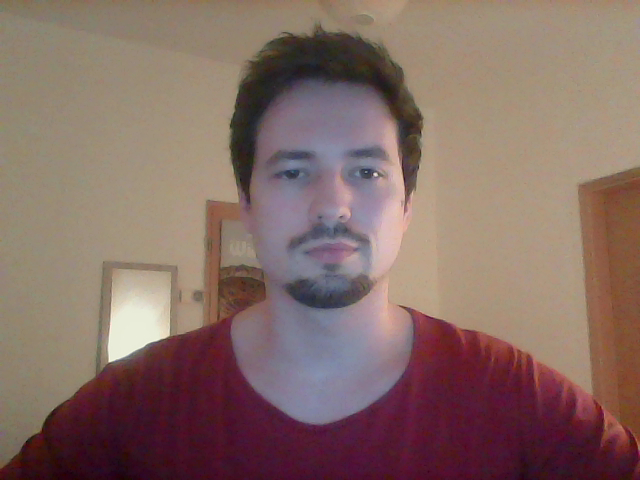

In [125]:
from IPython.display import Image, display

img_path = '/content/webcamphoto.jpg'

try:
  filename = take_photo(img_path, 1)
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
#from IPython.display import Image, display
#display(Image(img_path))
img = cv2.imread(img_path)

Let's take a look at the grayscale image. Usually we would display it using "cv2.imshow('my_windows_name',img)". If you try that, Google Colab will you an error message and explanation why that wouldn't work here. To fix this I use a patch Colab supplies.

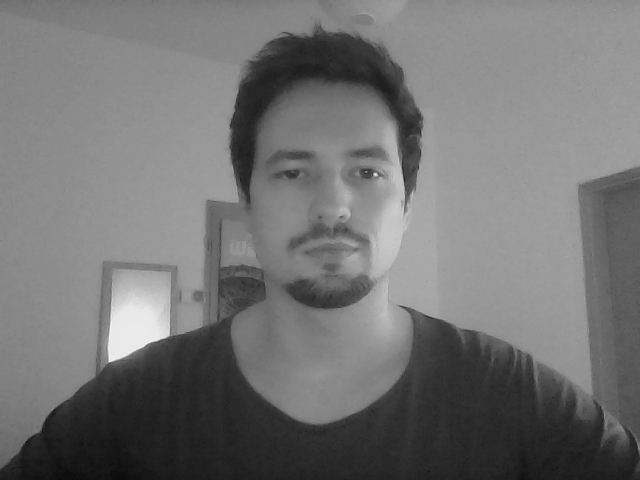

In [127]:
from google.colab.patches import cv2_imshow

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [0]:
# Define colors for gender prediction
labels_dict_gender = {0:'male',1:'female'}
color_dict_gender = {0:(252, 186, 3),
                     1:(216, 168, 224)}

# Define colors for age prediction
labels_dict_age = {0:'0-14',1:'15-25',2:'26-40',3:'40-60',4:'60+'}
color_dict_age = {0:(255,215,0),
                  1:(255,165,0),
                  2:(255,140,0),
                  3:(255,69,0),
                  4:(220,20,60)}

Loading the haarcascade frontalface classifier needs a slightly different implementation in Google Colab as well.

In [0]:
!pip install git+git://github.com/PnS2019/pnslib.git

In [0]:
from pnslib import utils

face_cascade = cv2.CascadeClassifier(
    utils.get_haarcascade_path('/content/haarcascade_frontalface_default.xml'))

Can the model find all faces in the snapshot?

In [128]:
faces = face_cascade.detectMultiScale(gray,1.3,5)  
faces

array([[227,  95, 202, 202]], dtype=int32)

In [0]:
for (x,y,w,h) in faces:
    # Black and white image
    face_img = gray[y:y+w,x:x+w]

    # Prepare webcam input for gender prediction
    resized_gender = cv2.resize(face_img,(224,224))
    resized_gender = cv2.cvtColor(resized_gender,cv2.COLOR_GRAY2RGB)
    reshape_gender=np.expand_dims(resized_gender,axis=0)
    normalized_gender = reshape_gender/255.0

    # Prepare webcam input for age prediction
    resized_age = cv2.resize(face_img,(32,32))
    resized_age = cv2.cvtColor(resized_age,cv2.COLOR_GRAY2RGB)
    reshape_age = np.expand_dims(resized_age,axis=0)
    normalized_age = reshape_age/255.0
    
    # Predict gender
    class_predictions_gender = model_gender.predict(normalized_gender)
    prediction_gender = np.argmax(class_predictions_gender, axis=-1)[0]  

    # Predict age
    class_predictions_age = model_age.predict(normalized_age)
    prediction_age = np.argmax(class_predictions_age, axis=-1)[0] 
    
    # Draw bounding box, 
    # color is chosen according to gender
    cv2.rectangle(img, (x,y), (x+w,y+h), 
                  color_dict_gender[prediction_gender], 2)
    
    # Put gender label 25px above bounding box,
    # color is chosen according to gender prediction
    cv2.putText(img, 'Gender: ' + labels_dict_gender[prediction_gender], 
                (x,y-25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_dict_gender[prediction_gender], 2)
    
    # Put age label 5px above bounding box,
    # color is chosen according to age prediction
    cv2.putText(img, 'Age: ' + labels_dict_age[prediction_age], 
                (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_dict_age[prediction_age], 2)

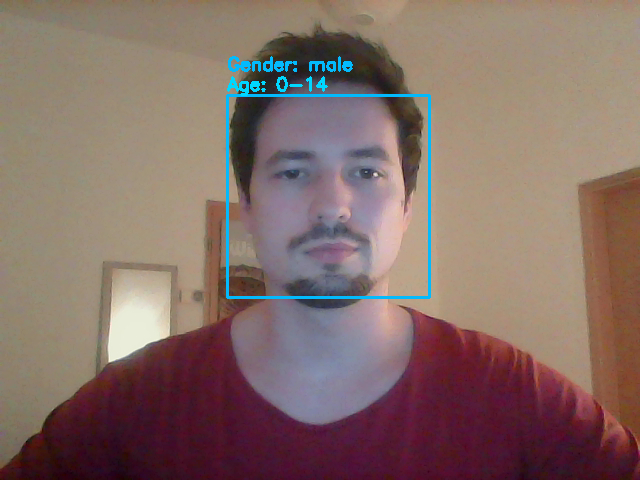

In [130]:
  # Display webcam image including all bounding boxes and predictions
  cv2_imshow(img)

Well, while the model detected my face and got my gender right, it got my age just ever so slightly wrong :) Judging by the 30 test cases shown in the age model section above though, I'm pretty confident it generally works fine.

When running the long script supplied above on your local machine, your webcam will open and we will also see the live feed coming from our webcam with the predictions continuously highlighted there instead of the static image you get in this notebook.

But please remember, this might give you fluctuating predictions as the model is not pin-point accurate. 

Nevertheless, you will enjoy the result. Also feel free to make changes to this code as per your requirement and play with the models to achieve even better accuracy and result. 

This project was just to show you and get yourself interested in the field of Deep Learning. Computer Vision in Deep Learning is pretty interesting and we hope you enjoyed making this project.

Happy Coding;).